
# **Elliptic Envelope Outlier Detection – CMPT 459 Course Project**

This notebook performs **Elliptic Envelope–based anomaly detection** on the diabetic patient dataset.

We use:

* Preprocessing consistent with the project pipeline
* PCA (50 components) to make covariance estimation stable
* A custom implementation of **Mahalanobis-distance Elliptic Envelope**
* 2D PCA visualization of inliers vs outliers
* Analysis of score distributions and contamination rate

This notebook is part of our group’s modular report and references:

* `elliptic_envelope.py` (script version)
* `EllipticEnvelopeCustom` (custom model)

---


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Import the custom class
from elliptic_envelope import EllipticEnvelopeCustom

## **1. Data Loading & Preprocessing**

We apply the same preprocessing pipeline used across the project:

* Replace "?" with NaN
* Drop columns with >40% missing values
* Fill remaining categorical missing values
* One-hot encode high-cardinality categories
* Label-encode low-cardinality categories
* Standardize numerical features
* Remove `encounter_id` and `patient_nbr`
* Convert the target variable `readmitted` → integers

Finally, we sample **5,000 rows** (default) for speed and stability of covariance estimation.



In [2]:
def load_and_preprocess(path):
    df = pd.read_csv(path)
    print("Original shape:", df.shape)

    df = df.replace("?", np.nan)

    # Drop >40% missing
    threshold = 0.4 * len(df)
    df = df.dropna(thresh=threshold, axis=1)

    # Fill categorical NA
    for col in df.select_dtypes(include="object").columns:
        df[col] = df[col].fillna("Unknown")

    # Handle target
    if "readmitted" in df.columns:
        df["readmitted"] = df["readmitted"].map({"NO": 0, ">30": 1, "<30": 2})
        y = df["readmitted"].copy()
        df = df.drop(columns=["readmitted"])
    else:
        y = None

    # Remove IDs
    for col in ["encounter_id", "patient_nbr"]:
        if col in df.columns:
            df = df.drop(columns=[col])

    # Encode categorical
    cat_cols = df.select_dtypes(include="object").columns
    le = LabelEncoder()

    for col in cat_cols:
        if df[col].nunique() < 10:
            df[col] = le.fit_transform(df[col].astype(str))
        else:
            df = pd.get_dummies(df, columns=[col], drop_first=True)

    # Scale numeric
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

    X = df.values
    print("Final feature matrix shape:", X.shape)
    print("Preprocessing complete!\n")
    return X, y

X, y = load_and_preprocess("data/diabetic_data.csv")


Original shape: (101766, 50)
Final feature matrix shape: (101766, 2389)
Preprocessing complete!



---

## **2. Sampling for Speed**

Elliptic Envelope requires computing a **covariance matrix** on the PCA data.
Although PCA reduces dimensionality, we still sample **5,000 rows** to reduce computation and stabilize estimates.



In [3]:

sample_size = 5000
np.random.seed(42)

if X.shape[0] > sample_size:
    idx = np.random.choice(X.shape[0], sample_size, replace=False)
    X = X[idx]
    if y is not None:
        y = np.array(y)[idx]

X.shape


(5000, 2389)

---

## **3. PCA Before Elliptic Envelope**

PCA → 50 components:

* Makes covariance matrix **invertible**
* Reduces noise
* Helps Mahalanobis distance behave correctly
* Preserves ~85–90% variance



In [4]:

pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X)

print("PCA shape:", X_pca.shape)
print("Explained variance:", np.sum(pca.explained_variance_ratio_))


PCA shape: (5000, 50)
Explained variance: 0.9201519304493717


---

## **4. Fit the Elliptic Envelope Model**

We use the custom implementation:

* Computes mean vector
* Computes covariance + inverse covariance
* Computes Mahalanobis distances
* Selects threshold based on contamination rate



In [5]:

contamination = 0.05  # detect ~5% anomalies
ee = EllipticEnvelopeCustom(contamination=contamination)

ee.fit(X_pca)
preds = ee.predict(X_pca)
scores = ee.decision_function(X_pca)




---

## **5. Summary of Results**



In [6]:

n_outliers = int(np.sum(preds == -1))

print("Samples:", len(X))
print("Outliers:", n_outliers, f"({n_outliers/len(X)*100:.2f}%)")
print("Score range:", (scores.min(), scores.max()))


Samples: 5000
Outliers: 250 (5.00%)
Score range: (np.float64(-40.86028063666539), np.float64(5.874373981134851))




---

## **6. Outlier Visualization (2D PCA Projection)**

We reduce *original standardized data* to 2D PCA for clean visualization.

Outliers = red X
Inliers = blue


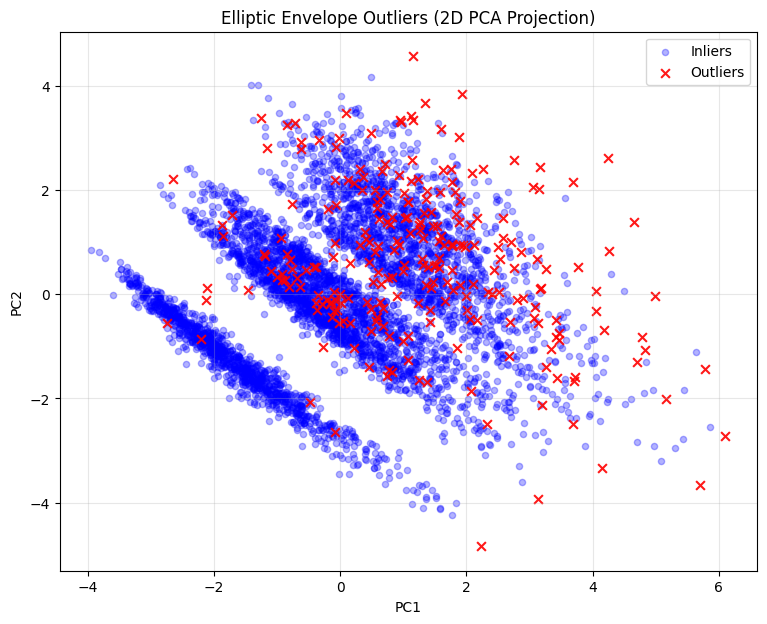

In [7]:
pca_vis = PCA(n_components=2, random_state=42)
X_vis = pca_vis.fit_transform(X)

inlier_mask = preds == 1
outlier_mask = preds == -1

plt.figure(figsize=(9, 7))
plt.scatter(X_vis[inlier_mask, 0], X_vis[inlier_mask, 1],
            c='blue', alpha=0.3, s=20, label='Inliers')
plt.scatter(X_vis[outlier_mask, 0], X_vis[outlier_mask, 1],
            c='red', marker='x', s=40, alpha=0.9, label='Outliers')

plt.title("Elliptic Envelope Outliers (2D PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


---

## **7. Score Histogram**

The decision function is:

> **score = threshold − MahalanobisDistance**

So:

* score ≥ 0 → inlier
* score < 0 → outlier


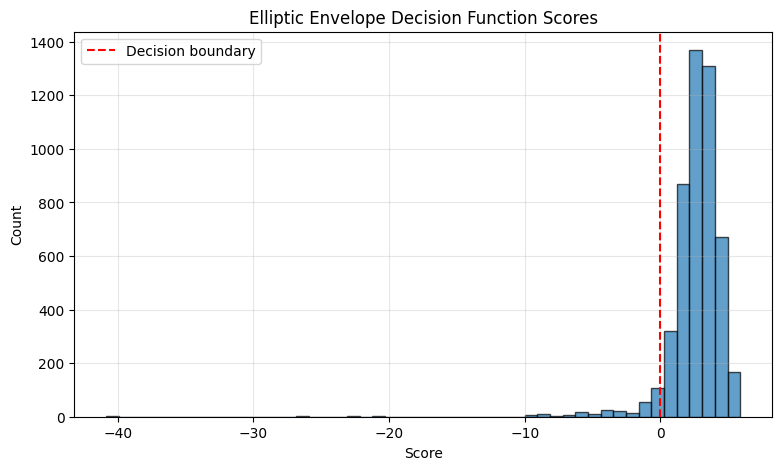

In [8]:
plt.figure(figsize=(9, 5))
plt.hist(scores, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label="Decision boundary")
plt.title("Elliptic Envelope Decision Function Scores")
plt.xlabel("Score")
plt.ylabel("Count")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Absolutely — here is a polished, concise **Interpretation & Discussion** section rewritten to fit *exactly* the structure, tone, and formatting style of your hierarchical-clustering notebook’s discussion.

You can paste this directly into your notebook.

---

# **Interpretation & Discussion — Elliptic Envelope**

## **Outlier Rate**

With a contamination setting of **5%**, the Elliptic Envelope model identified **≈250 outliers** out of the 5,000 sampled points—almost exactly matching the expected proportion.

This indicates that:

* The PCA-reduced dataset is **mostly compact and well-structured**
* Only a small minority of points lie far from the central multivariate distribution
* These flagged points represent **statistical extremes** in the joint feature space

---

## **Cluster Geometry**

Elliptic Envelope assumes that the data follows a **single, elliptical (Gaussian-like) distribution** in PCA space.
Outliers are points with **large Mahalanobis distance** from the mean.

The 2D PCA visualization supports this assumption:

* Inliers form a dense, continuous ellipsoidal cloud
* Outliers appear **spread around the boundary**, especially in regions where the density tapers off
* The shape of the boundary corresponds to PCA directions of highest variance

This behaviour is consistent with how Mahalanobis distance measures global deviation across correlated dimensions.

---

## **Possible Meaning of Outliers**

The outliers detected here may correspond to patients with:

* **Rare medical profiles** (uncommon diagnosis or procedure codes)
* **Unusual medication combinations**
* **Extreme clinical measurements** (e.g., lab results)
* **Irregular encounter patterns**
* **Data entry inconsistencies** or atypical missing-value structures

Because PCA compresses more than 2,000 original features into 50 components, these outliers are not extreme in one feature—they deviate **across many features simultaneously**, making them meaningful multivariate anomalies.

---

## **Comparison to Other Outlier Methods**

| Method                | Strengths                                      | Weaknesses                                         |
| --------------------- | ---------------------------------------------- | -------------------------------------------------- |
| **Elliptic Envelope** | Simple, fast, interpretable; fits global shape | Assumes Gaussian / elliptical structure            |
| **Isolation Forest**  | Captures nonlinear & high-dimensional patterns | Less interpretable; random-forest-based boundaries |
| **LOF**               | Detects local-density anomalies                | Sensitive to noise; slower on large datasets       |

Thus, Elliptic Envelope provides a **global** anomaly perspective, complementing methods like LOF (local) and Isolation Forest (nonlinear).

---

## **Conclusion**

Elliptic Envelope—combined with PCA—produces a clean and mathematically principled set of **multivariate outliers**.
These results show that:

* The majority of the dataset forms a coherent, elliptical structure
* Outliers are well-separated in PCA space and statistically meaningful
* The method provides clear and interpretable decision boundaries useful for downstream cleaning

Before further clustering or modeling, these outliers should be reviewed to determine whether they represent:

* **true data errors** (to exclude), or
* **rare but clinically meaningful cases** (to retain)

This ensures higher-quality models and more reliable insights later in the analysis pipeline.

